## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from data import ParenthesizationDataset
from model import Model
from train import train_one_epoch, compute_validation_loss
from evaluate import evaluate_model, predict
from interpret import plot_linear_layer, incorrect_predictions, token_contributions, activations
import matplotlib.pyplot as plt

## Initialize model, loaders, loss function, optimizer
`checkpoint_epochs` is the number of epochs before a checkpoint is saved. Use `data_prefix` to choose the "small" dataset.

In [2]:
epochs = 20
checkpoint_epochs = 2
batch_size = 64
d_model = 16
nhead = 4
num_layers = 1
n_vocab = 4
data_prefix = "small_"

training_dataset = ParenthesizationDataset(f"{data_prefix}training")
validation_dataset = ParenthesizationDataset(f"{data_prefix}validation")
test_dataset = ParenthesizationDataset(f"{data_prefix}test")

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = Model(n_vocab, d_model, nhead, num_layers)
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
`start_epoch` can be set to a value greater than 0 to resume training from a checkpoint.

In [3]:
start_epoch = 0

training_loss = []
validation_loss = []
best_validation_loss = float("inf")

def save():
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': training_loss,
      'validation_loss': validation_loss
    }, f"checkpoints/epoch_{epoch}.pth")

def resume(epoch):
    global training_loss, validation_loss
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_loss = checkpoint["training_loss"]
    validation_loss = checkpoint["validation_loss"]

if start_epoch > 0:
    resume(start_epoch)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    model.train(True)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer))
    validation_loss.append(compute_validation_loss(validation_loader, model, loss_fn))
    print(f"Epoch {epoch}, Training Loss {training_loss[-1]}, Validation Loss {validation_loss[-1]}")

    if (epoch+1) % checkpoint_epochs == 0:
        save()

Epoch 0, Training Loss 0.6937753116656423, Validation Loss 0.6768517213709214
Epoch 1, Training Loss 0.5179569658823878, Validation Loss 0.33501582636552696
Epoch 2, Training Loss 0.3241558144604804, Validation Loss 0.260497719633813
Epoch 3, Training Loss 0.26701373003346124, Validation Loss 0.22353203916082195
Epoch 4, Training Loss 0.222614520871632, Validation Loss 0.18391611763075286
Epoch 5, Training Loss 0.18801948662146664, Validation Loss 0.13819615396798826
Epoch 6, Training Loss 0.17702441979528416, Validation Loss 0.13633262643627092
Epoch 7, Training Loss 0.12543503046761326, Validation Loss 0.09462943731569777
Epoch 8, Training Loss 0.12305281812362531, Validation Loss 0.21401840360725627
Epoch 9, Training Loss 0.19676515095421113, Validation Loss 0.2061129674023273
Epoch 10, Training Loss 0.1308354910959649, Validation Loss 0.12641062456018784
Epoch 11, Training Loss 0.11246083313128749, Validation Loss 0.21585468451182047
Epoch 12, Training Loss 0.11531203183471903, Val

# Plot the loss curve for training and validation

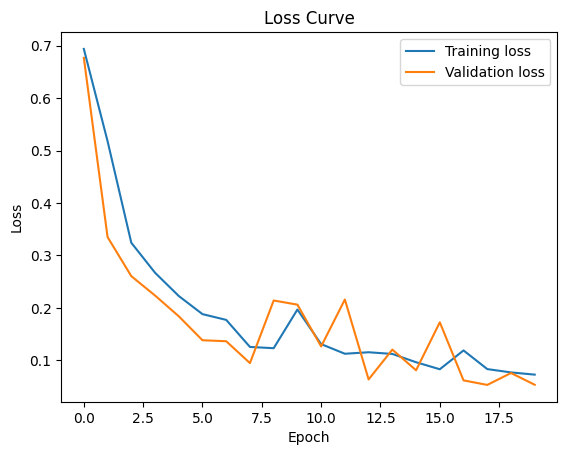

In [4]:
# Plot loss function
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Evaluate the model and plot the confusion matrix

c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training data set accuracy:
Accuracy for class 0 = 95.31059683313033%
Accuracy for class 1 = 99.330900243309%
Overall accuracy = 97.32197200243458%


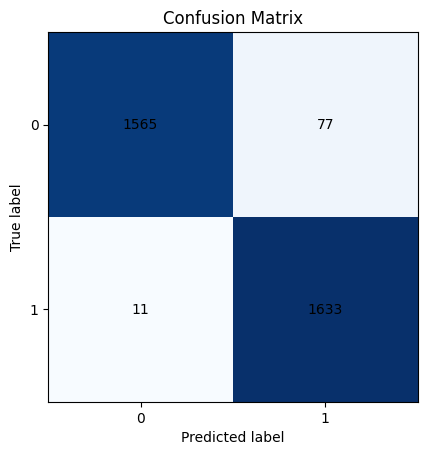

Validation data set accuracy:
Accuracy for class 0 = 98.03921568627452%
Accuracy for class 1 = 99.01960784313725%
Overall accuracy = 98.52941176470588%


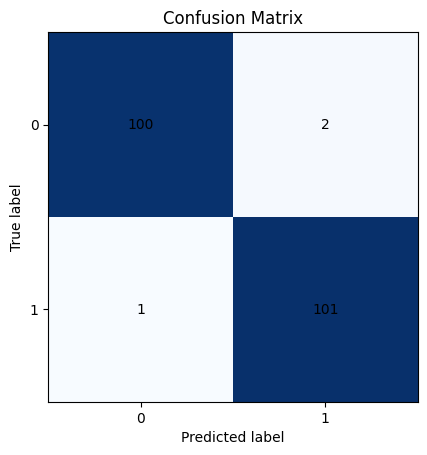

Test data set accuracy:
Accuracy for class 0 = 95.45454545454545%
Accuracy for class 1 = 98.7012987012987%
Overall accuracy = 97.07792207792208%


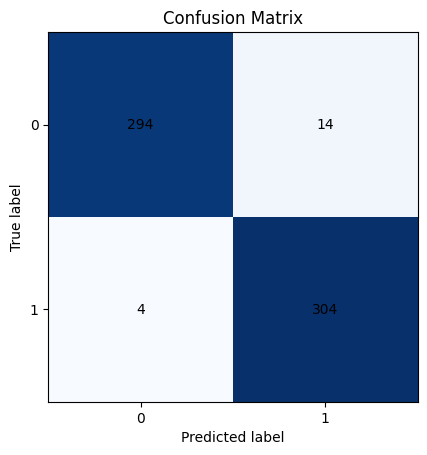

In [5]:
training_confusion_matrix = evaluate_model(model, training_loader)
validation_confusion_matrix = evaluate_model(model, validation_loader)
test_confusion_matrix = evaluate_model(model, test_loader)

print("Training data set accuracy:")
training_confusion_matrix.print_accuracy()
training_confusion_matrix.plot()

print("Validation data set accuracy:")
validation_confusion_matrix.print_accuracy()
validation_confusion_matrix.plot()

print("Test data set accuracy:")
test_confusion_matrix.print_accuracy()
test_confusion_matrix.plot()

# Interpretation
In this section you will try various techniques to interpret the model. Insert additional notebook cells as need to do the following:

1. Construct some test cases of varying lengths and display the model's predictions.
2. Compute the list of incorrect predictions and display some examples of them.
3. For each incorrect prediction, plot the token contributions as a heatmap.
4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.
5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
6. Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.

In [6]:
# Import necessary modules
import torch
from data import padding_mask, parenthesization_to_tensor
from model import Model

# Define some test cases of varying lengths
test_cases = ["()", "(())", "((()))", "()()", "(()(()))", ")(", "())", "(()))", "(()()", "((()"]

# Convert test cases to tensors
test_tensors = [parenthesization_to_tensor(tc) for tc in test_cases]

# Load the model
model = Model(n_vocab=4, d_model=16, nhead=4, num_layers=1)  # Adjust parameters as necessary
model.load_state_dict(torch.load('checkpoints/epoch_19.pth')['model_state_dict'])
model.eval()

# Display model predictions for each test case
for i, test_tensor in enumerate(test_tensors):
    prediction = model(test_tensor.unsqueeze(0), mask=padding_mask(test_tensor.unsqueeze(0)))
    predicted_labels = torch.argmax(prediction, dim=2)
    predicted_label = predicted_labels[0, 0].item()
    print(f"Test case: {test_cases[i]}, Prediction: {predicted_label}")

Test case: (), Prediction: 1
Test case: (()), Prediction: 1
Test case: ((())), Prediction: 1
Test case: ()(), Prediction: 1
Test case: (()(())), Prediction: 1
Test case: )(, Prediction: 1
Test case: ()), Prediction: 0
Test case: (())), Prediction: 1
Test case: (()(), Prediction: 0
Test case: (((), Prediction: 0


In [7]:
# Import necessary modules
from torch.utils.data import DataLoader
from data import ParenthesizationDataset

# Load test dataset and create DataLoader
test_dataset = ParenthesizationDataset(type="test")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Get incorrect predictions
incorrect_preds = incorrect_predictions(model, test_loader)

# Display some examples of incorrect predictions
for label, incorrects in enumerate(incorrect_preds):
    print(f"\nIncorrect predictions for label {label}:")
    for incorrect in incorrects[:5]:  # Display first 5 incorrect predictions for each label
        print(incorrect)


Incorrect predictions for label 0:
[2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Incorrect predictions for label 1:
[2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 


Incorrect predictions for label 0:


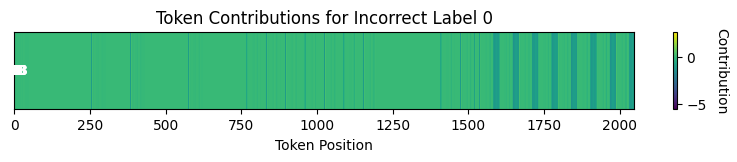

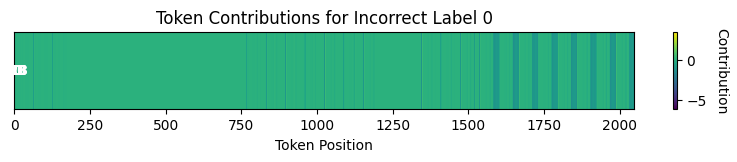

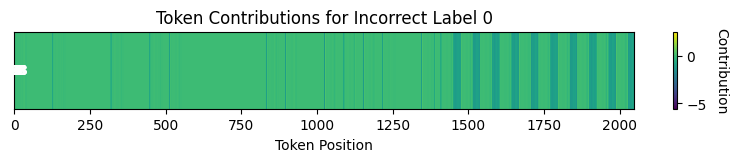

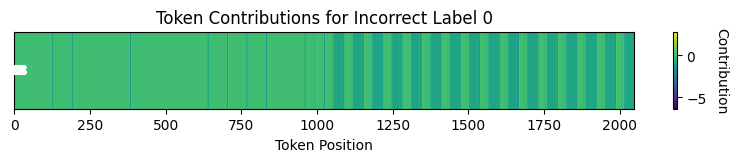

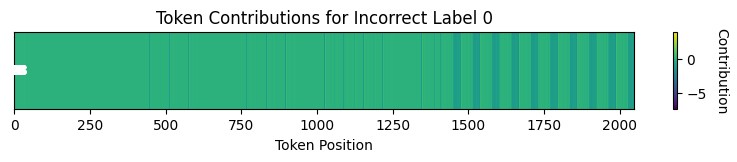


Incorrect predictions for label 1:


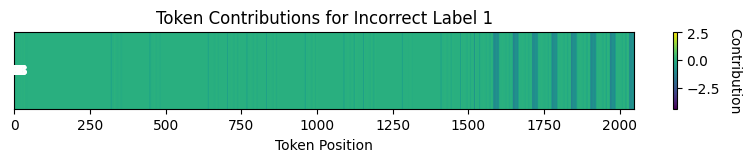

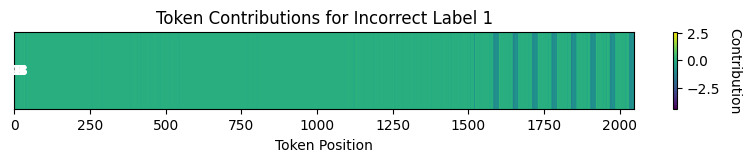

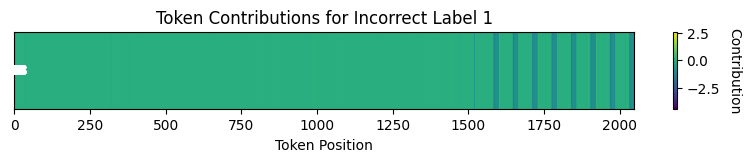

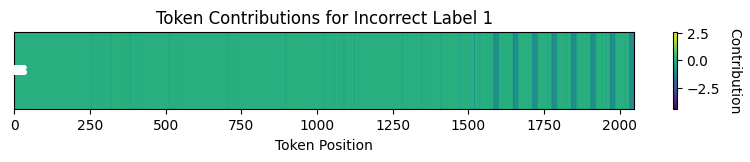

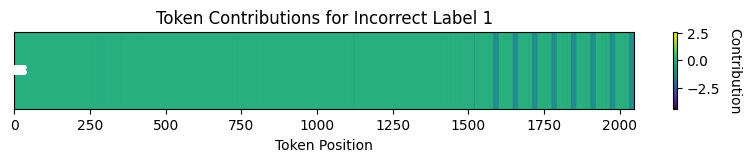

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_contributions(sequence, contributions, title="Token Contributions"):
    """
    Plots a heatmap of token contributions for a given sequence using matplotlib.
    
    Args:
        sequence (list): The input sequence of tokens.
        contributions (list): The contributions of each token.
        title (str): The title for the heatmap.
    """
    # Convert contributions to a numpy array and ensure it has shape (1, N)
    contributions = np.array(contributions)
    if contributions.ndim > 2:
        contributions = contributions.reshape(1, -1)

    fig, ax = plt.subplots(figsize=(10, 1))
    heatmap = ax.imshow(contributions, aspect='auto', cmap='viridis')

    # Add color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Contribution', rotation=270, labelpad=15)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel("Token Position")
    ax.set_yticks([])  # Hide y-axis ticks

    # Annotate the heatmap with the sequence tokens
    for i in range(len(sequence)):
        ax.text(i, 0, sequence[i], ha='center', va='center', color='white')

    plt.show()

# Example usage
# Assuming `token_contributions` is a function that returns the contributions for each token
for label, incorrects in enumerate(incorrect_preds):
    print(f"\nIncorrect predictions for label {label}:")
    for incorrect in incorrects[:5]:  # Display first 5 incorrect predictions for each label
        tensor_input = torch.tensor(incorrect)
        contributions = token_contributions(model, tensor_input)
        plot_token_contributions(incorrect, contributions, title=f"Token Contributions for Incorrect Label {label}")

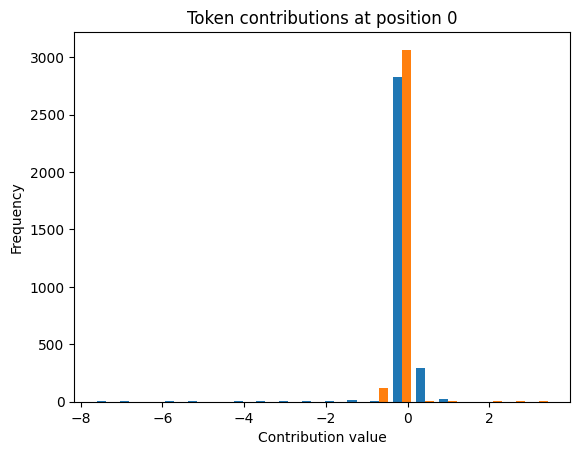

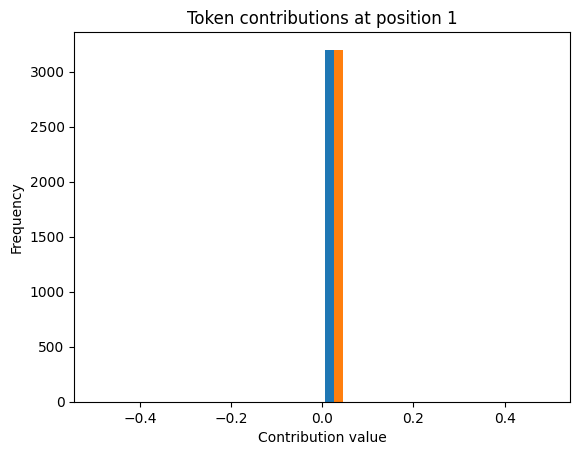

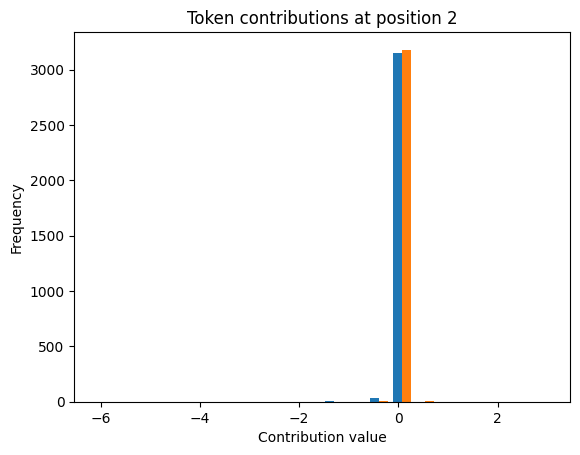

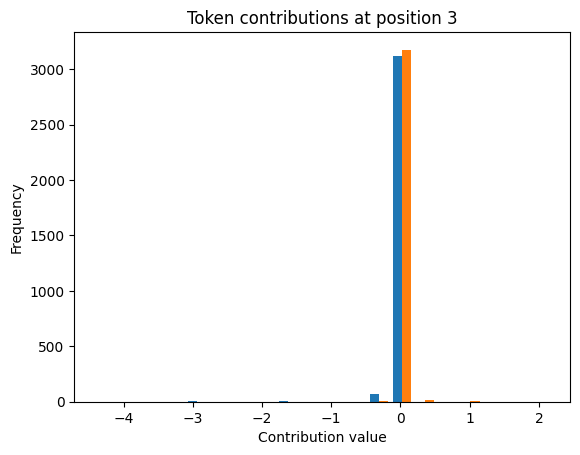

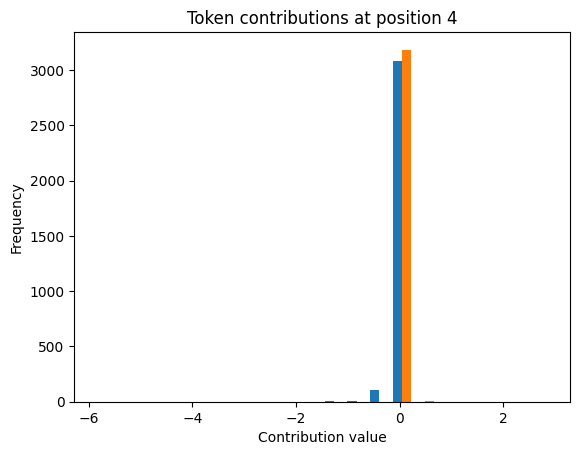

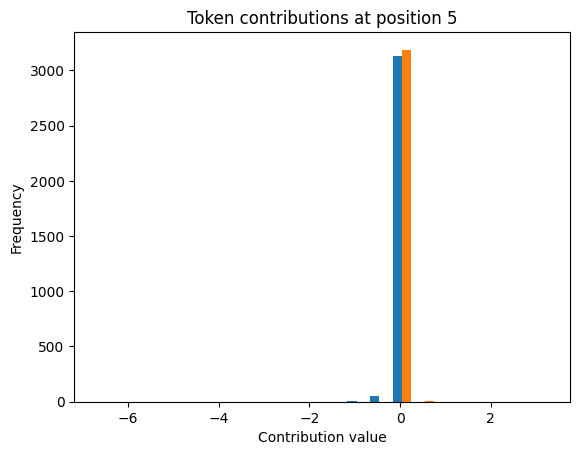

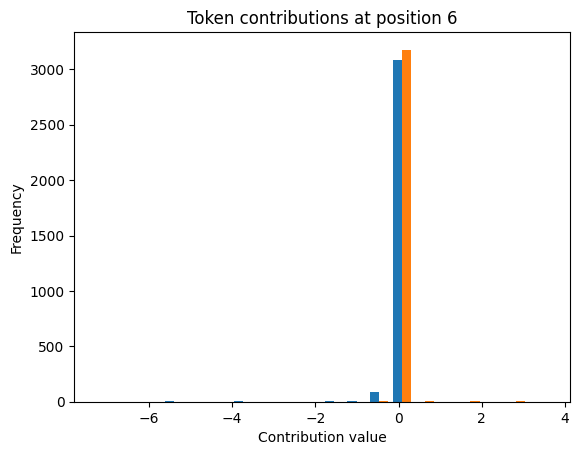

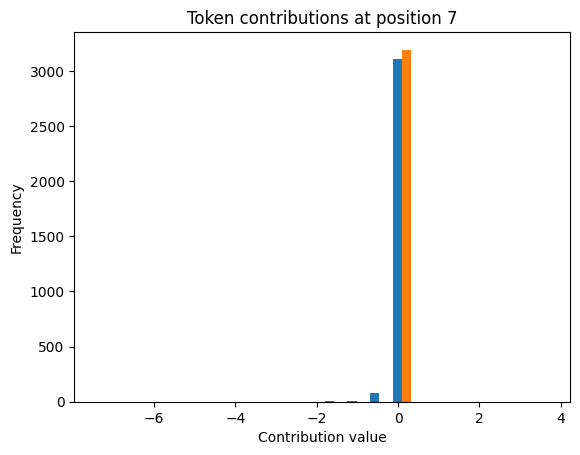

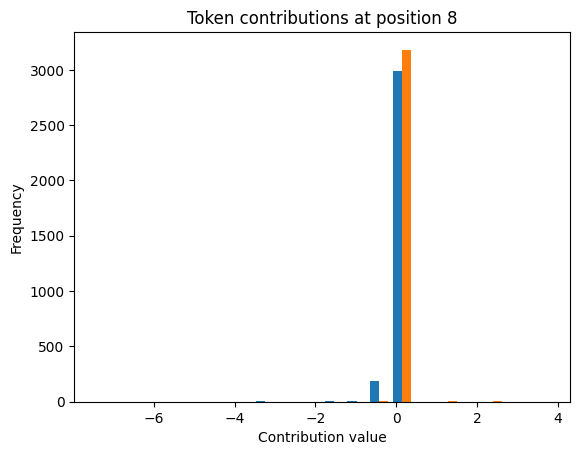

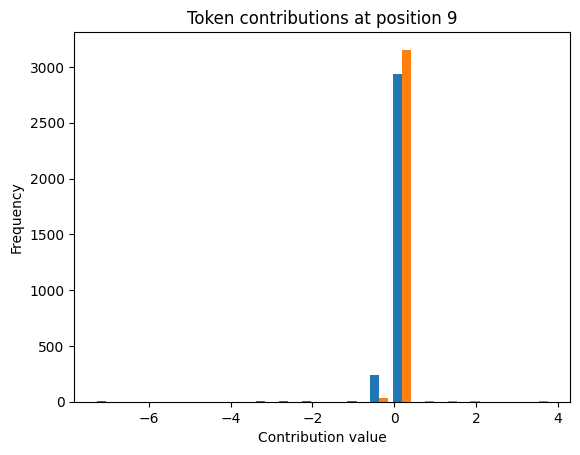

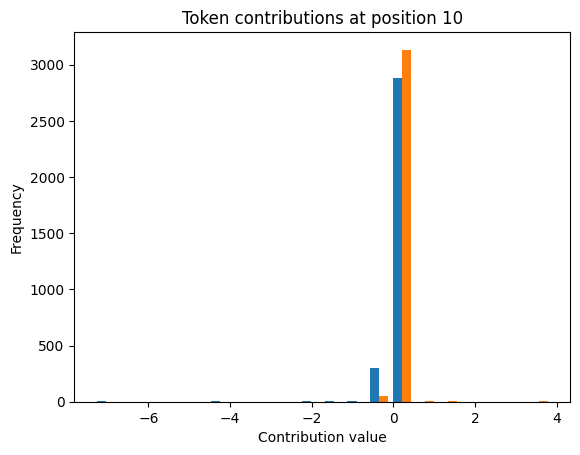

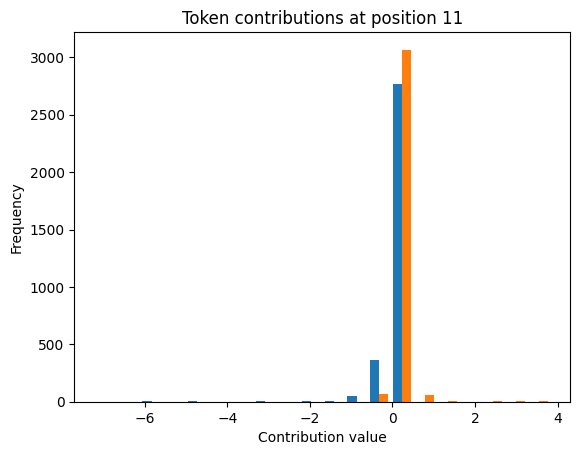

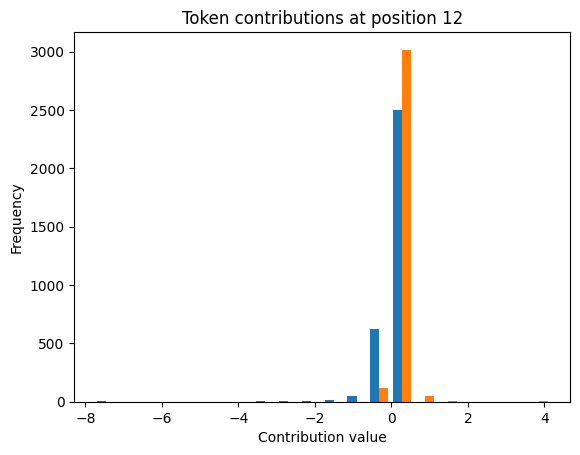

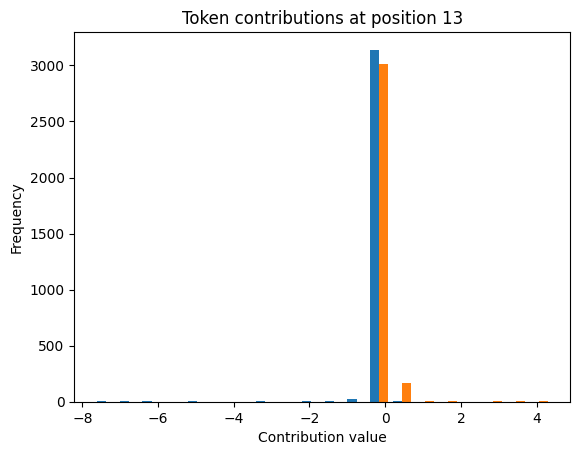

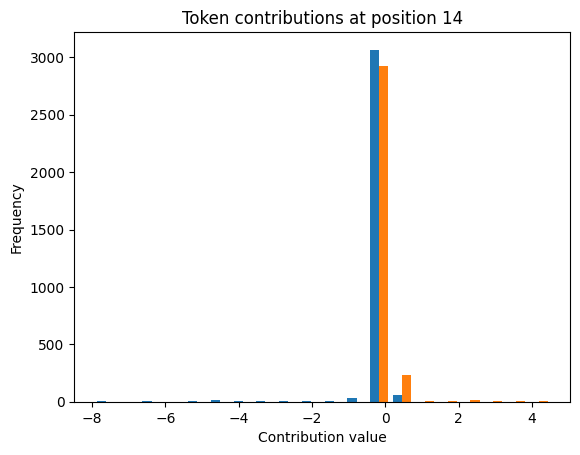

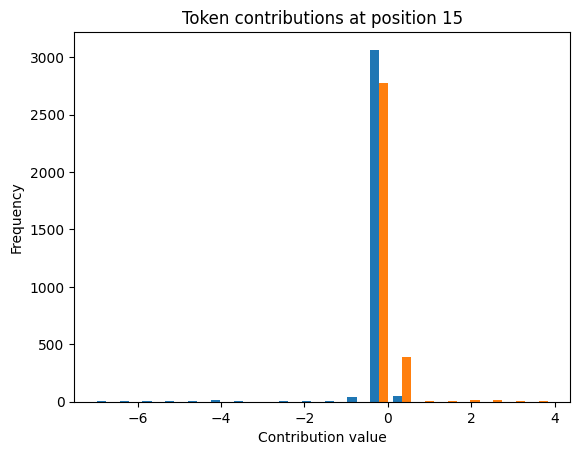

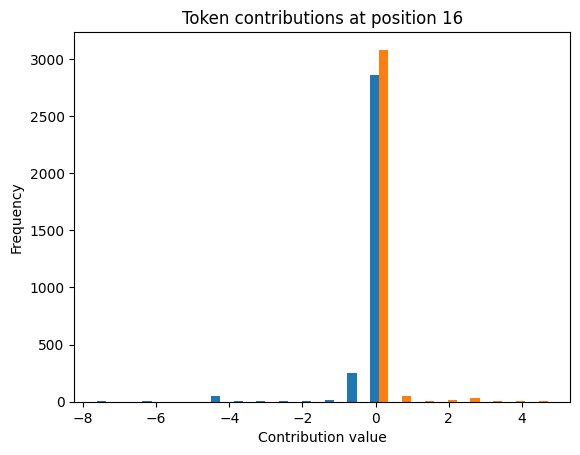

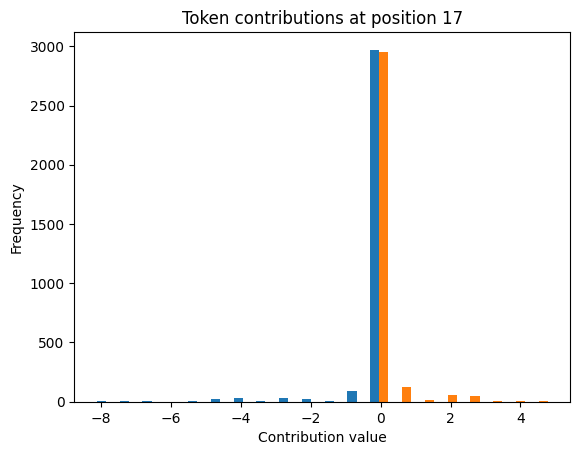

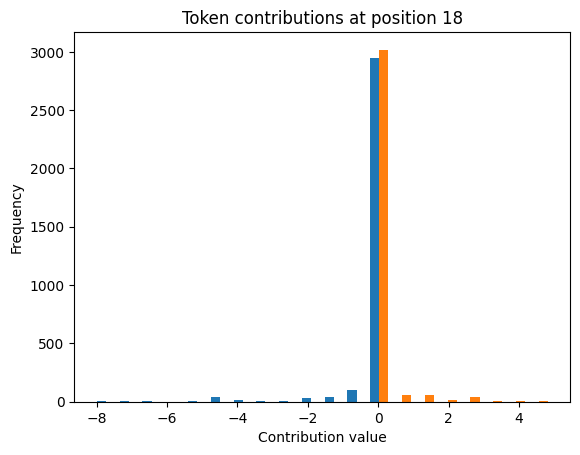

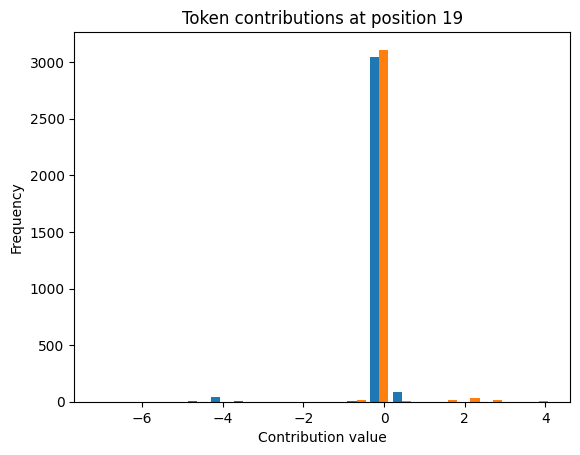

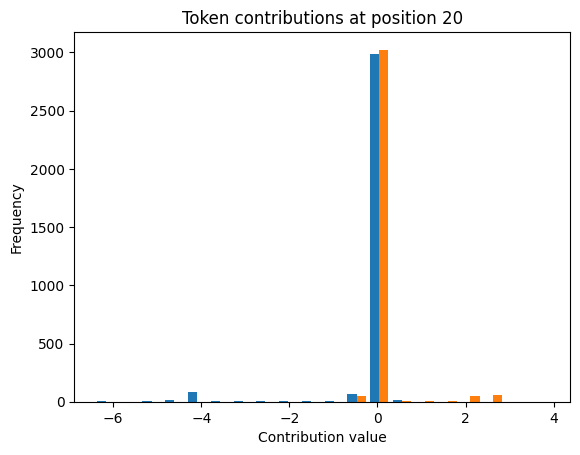

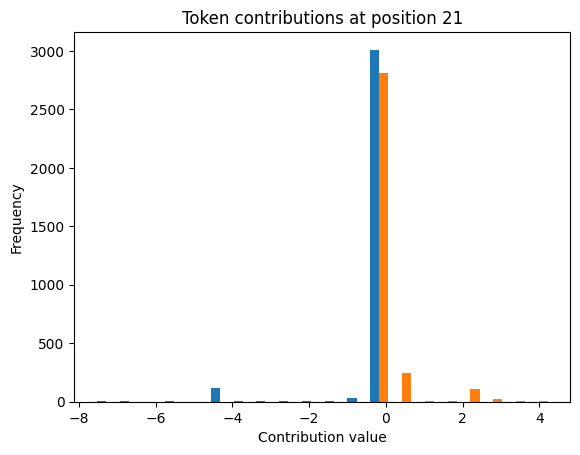

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def batch_token_contributions(model, inputs):
    """
    Calculates the contributions of each token in the batch of input sequences to each class in the model's
    predicted output. The contribution of a single token is calculated as the difference between the
    original prediction and the prediction after masking the token.

    Args:
        model (torch.nn.Module): The trained model.
        inputs (torch.Tensor): A tensor representing a batch of input sequences.

    Returns:
        List[List[float]]: A list of lists of contributions of each token to the model's output.
    """
    model.eval()  # Set the model to evaluation mode
    contributions = []

    with torch.no_grad():
        original_output = model(inputs, mask=padding_mask(inputs))
        original_predictions = original_output.cpu().numpy()

    for i in range(inputs.size(1)):  # Loop over the token positions
        masked_inputs = inputs.clone()
        masked_inputs[:, i] = 0  # Mask the token (assuming 0 is the mask token)

        with torch.no_grad():
            masked_output = model(masked_inputs, mask=padding_mask(masked_inputs))
            masked_predictions = masked_output.cpu().numpy()

        # Calculate the contribution as the difference in predictions
        contribution = original_predictions - masked_predictions
        contributions.append(contribution)

    return contributions

# Collect token contributions for each position
position_contributions = [[] for _ in range(22)]

# Limiting the number of test samples for demonstration purposes
num_samples = 100

for i, data in enumerate(test_loader):
    if i >= num_samples:
        break

    inputs, _ = data
    inputs = inputs.squeeze(0)  # Remove the batch dimension
    contributions = batch_token_contributions(model, inputs.unsqueeze(0))

    for j in range(min(len(inputs), 22)):  # Limit to position 21
        position_contributions[j].extend(contributions[j])

# Plot histograms of token contributions for each position
for i in range(22):
    plt.figure()
    plt.hist(np.concatenate(position_contributions[i]), bins=20)
    plt.title(f"Token contributions at position {i}")
    plt.xlabel("Contribution value")
    plt.ylabel("Frequency")
    plt.show()


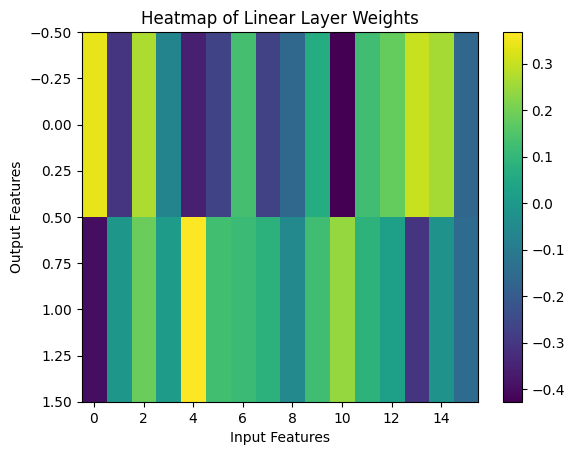

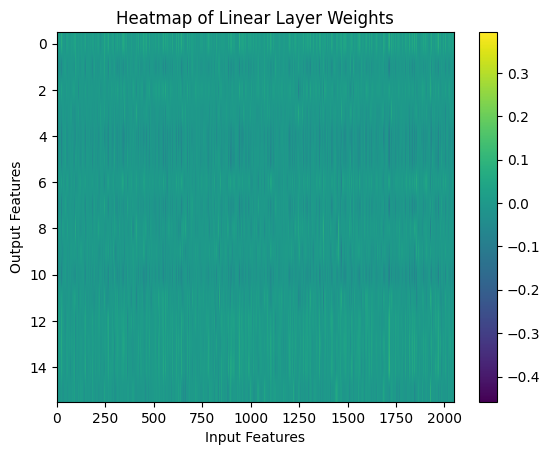

In [10]:
# Plot heatmap for the projection layer
plot_linear_layer(model.proj)

# Access the second linear layer in the CustomTransformerEncoderLayer
second_linear_layer = model.encoder.layers[0].linear2
plot_linear_layer(second_linear_layer)

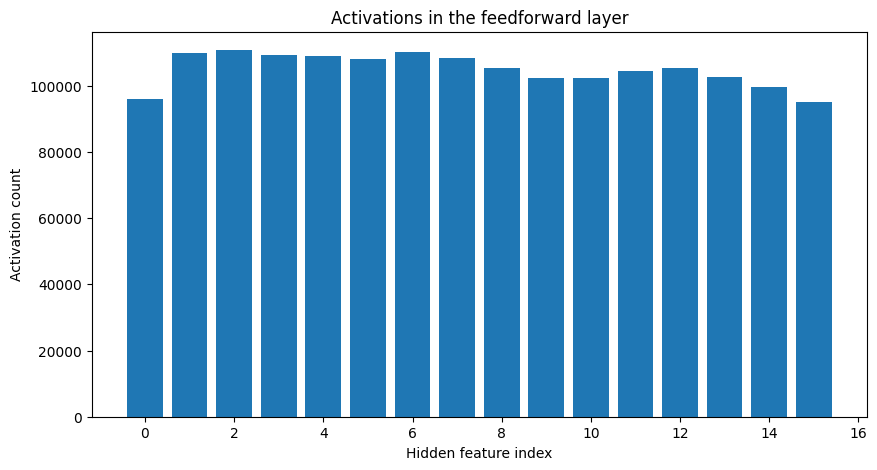

In [11]:
# Calculate activations in the feedforward layer
activations_count = activations(model, test_loader)

# Plot activations as histogram
plt.figure(figsize=(10, 5))
plt.bar(range(len(activations_count)), activations_count)
plt.title("Activations in the feedforward layer")
plt.xlabel("Hidden feature index")
plt.ylabel("Activation count")
plt.show()